# Topic

In this notebook, I'm trying to find a robust metric to compute the complexity of the data
represented as a set of discrete values

In [1]:
from liblibra_core import *
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from math import log, pi, gamma

import infomeasure as im

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWar

In [2]:
help(gaussian_kde)

Help on class gaussian_kde in module scipy.stats._kde:

class gaussian_kde(builtins.object)
 |  gaussian_kde(dataset, bw_method=None, weights=None)
 |  
 |  Representation of a kernel-density estimate using Gaussian kernels.
 |  
 |  Kernel density estimation is a way to estimate the probability density
 |  function (PDF) of a random variable in a non-parametric way.
 |  `gaussian_kde` works for both uni-variate and multi-variate data.   It
 |  includes automatic bandwidth determination.  The estimation works best for
 |  a unimodal distribution; bimodal or multi-modal distributions tend to be
 |  oversmoothed.
 |  
 |  Parameters
 |  ----------
 |  dataset : array_like
 |      Datapoints to estimate from. In case of univariate data this is a 1-D
 |      array, otherwise a 2-D array with shape (# of dims, # of data).
 |  bw_method : str, scalar or callable, optional
 |      The method used to calculate the bandwidth factor.  This can be
 |      'scott', 'silverman', a scalar constant o

In [3]:
z = []
for i in range(100):
    x = random.uniform(0.0, 1.0)
    z.append(x**2)

## 1. Naive approach

We are trying to compute Shannon entropy, but the numerical integration is sensitive to the size of the bins,
so it doesn't converge

In [4]:
counts, bin_edges = np.histogram(z, bins=100, density=True)

# Compute bin centers for plotting
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

dx = bin_edges[1] - bin_edges[0]
print(F"dx = {dx}")

S = sum( -counts[counts>0.0] * np.log(counts[counts>0.0]) ) * dx
print(F"S = {S}")

dx = 0.009797088808333626
S = -0.8265785427157958


In [5]:
#print(counts)
#print(bin_edges)
#print(bin_centers)

## 2. KDE estimator

How about we use a smooth fit to data before doing the integration?


Shannon entropy = -0.5701273669704433


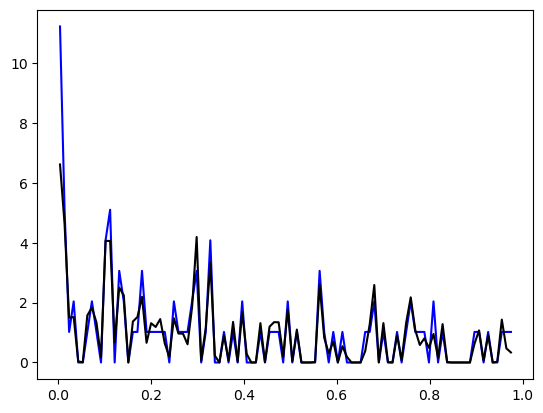

In [6]:
# Assume z is your 1D data
kde = gaussian_kde(z, 0.01)
#print(kde)

# Evaluate on a grid
#x = np.linspace(min(z), max(z), 10000)
x = bin_centers
p = kde(x)
#print(p)

# Avoid log(0) by clipping
p = np.clip(p, 1e-12, None)

dx = x[1] - x[0]
entropy = -np.sum(p * np.log(p)) * dx
print(f"Shannon entropy = {entropy}")

plt.plot(bin_centers, counts, color="blue")
plt.plot(x, p, color="black")

Shannon entropy = -0.07298957320759847


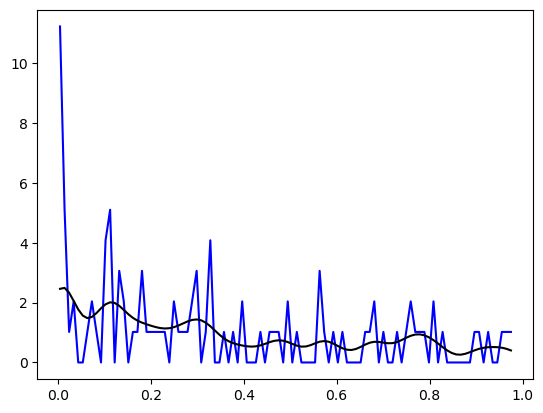

In [7]:
# Assume z is your 1D data
kde = gaussian_kde(z, 0.1)
#print(kde)

# Evaluate on a grid
#x = np.linspace(min(z), max(z), 10000)
x = bin_centers
p = kde(x)
#print(p)

# Avoid log(0) by clipping
p = np.clip(p, 1e-12, None)

dx = x[1] - x[0]
entropy = -np.sum(p * np.log(p)) * dx
print(f"Shannon entropy = {entropy}")

plt.plot(bin_centers, counts, color="blue")
plt.plot(x, p, color="black")

In [8]:
print(len(x))
print(len(p))

100
100


## 3. Kozachenko-Leonenko

In [11]:
def kozachenko_leonenko_entropy(data, k=3):
    """
    Estimate differential entropy using the Kozachenko-Leonenko estimator.
    
    Parameters:
        data: ndarray of shape (n_samples, n_dimensions)
        k: int, number of nearest neighbors (default=1)
    
    Returns:
        Estimated entropy (float)
    """
    n, d = data.shape
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    # Exclude the zero distance to itself at index 0
    epsilons = distances[:, k]
    
    # Constant: volume of unit ball in d dimensions
    cd = (np.pi ** (d / 2)) / gamma(1 + d / 2)
    
    entropy = (
        digamma(n) - digamma(k) +
        np.log(cd) +
        d * np.mean(np.log(epsilons))
    )
    return entropy / np.log(2)  # convert to bits

npts = len(z)
z = np.array(z).reshape(npts, 1)

entropy = kozachenko_leonenko_entropy(z)
print(f"KNN entropy ≈ {entropy}")

KNN entropy ≈ -0.38734132552933254


Now using the `infomeasure` library

In [15]:
h = im.entropy(z, approach="metric", k=3)
print(h)

-0.3873413649299504


In [24]:
# This discrete approach won't work since the variables are expected to be discrete
#h = im.entropy(z, approach="discrete", base=2)
#print(h)

# So let's do the continuous one:
h = im.entropy(z, approach="kernel", kernel="box", bandwidth=0.1)
print(h)

h = im.entropy(z, approach="kernel", kernel="box", bandwidth=0.01)
print(h)

h = im.entropy(z, approach="kernel", kernel="box", bandwidth=0.001)
print(h)


# So let's do the continuous one:
h = im.entropy(z, approach="kernel", kernel="gaussian", bandwidth=0.1, base='e')
print(h)

h = im.entropy(z, approach="kernel", kernel="gaussian", bandwidth=0.01)
print(h)

h = im.entropy(z, approach="kernel", kernel="gaussian", bandwidth=0.001)
print(h)

-0.09392675736231061
-0.7005558659051393
-2.493268322814923
-0.17518932258340233
-0.9151529357471722
-2.773645382558815


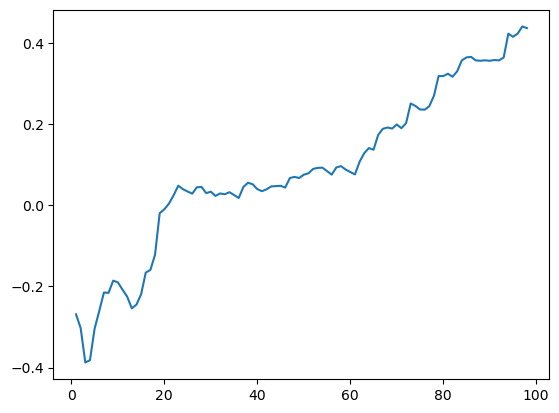

In [12]:
ks = list(range(1, 99))
s = []
for k in ks:
    entropy = kozachenko_leonenko_entropy(z, k)
    s.append(entropy)

plt.plot(ks, s)

## 4. Adaptive binning

Hwere is how Shannon entropy depends on the number of bins, for the same data

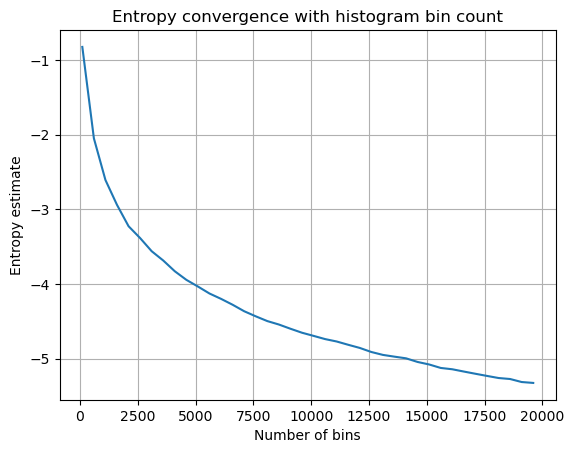

In [13]:
bins_list = np.arange(100, 20000, 500)
entropy_list = []

for bins in bins_list:
    counts, bin_edges = np.histogram(z, bins=bins, density=True)
    dx = bin_edges[1] - bin_edges[0]
    p = counts[counts > 0]
    entropy = -np.sum(p * np.log(p)) * dx
    entropy_list.append(entropy)

plt.plot(bins_list, entropy_list)
plt.xlabel("Number of bins")
plt.ylabel("Entropy estimate")
plt.title("Entropy convergence with histogram bin count")
plt.grid(True)
plt.show()